In [24]:
# imports
import os, pathlib, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import keras
from keras import layers

# seeds
tf.random.set_seed(42)
np.random.seed(42)

# load data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# footwear labels
footwear_ids = {5, 7, 9}
y_train_bin = np.isin(y_train, list(footwear_ids)).astype("int32")
y_test_bin  = np.isin(y_test,  list(footwear_ids)).astype("int32")

# normalize
x_train = (x_train.astype("float32") / 255.0)[..., np.newaxis]
x_test  = (x_test.astype("float32")  / 255.0)[..., np.newaxis]

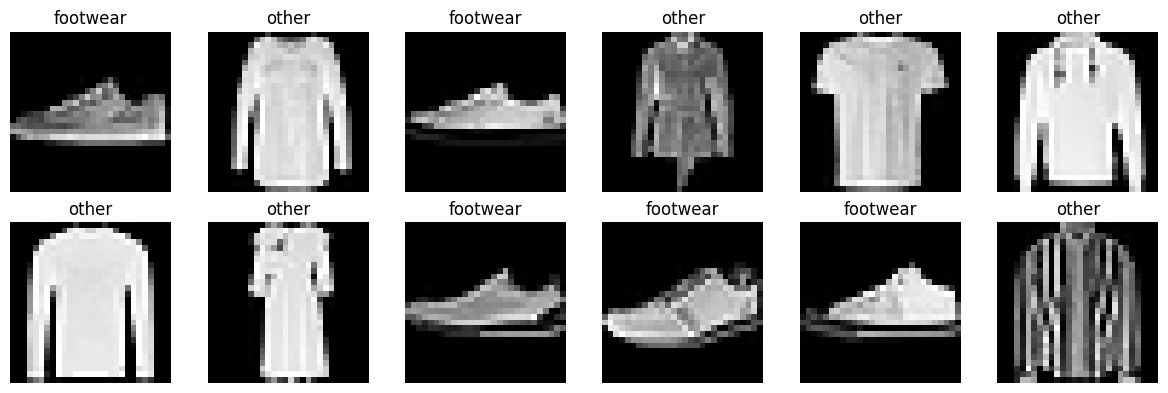

In [26]:

# validation split
val_frac = 0.1
n_val = int(len(x_train) * val_frac)
x_val, y_val = x_train[:n_val], y_train_bin[:n_val]
x_train, y_train_bin = x_train[n_val:], y_train_bin[n_val:]

# show images
def show_samples(x, y, n=12):
    idx = np.random.choice(len(x), size=n, replace=False)
    cols = 6
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i, j in enumerate(idx, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(x[j].squeeze(), cmap="gray")
        plt.title("footwear" if y[j]==1 else "other")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(x_train, y_train_bin, n=12)

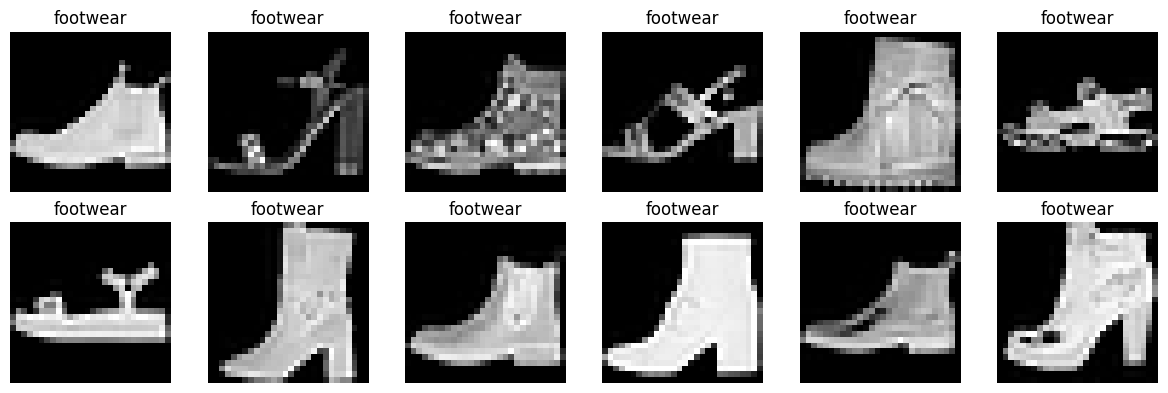

In [27]:
def show_footwear_samples(x, y, n=12):
    # indices where label == 1 (footwear)
    footwear_idx = np.where(y == 1)[0]
    if len(footwear_idx) == 0:
        print("no footwear samples found")
        return
    idx = np.random.choice(footwear_idx, size=min(n, len(footwear_idx)), replace=False)

    cols = 6
    rows = int(np.ceil(len(idx) / cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i, j in enumerate(idx, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(x[j].squeeze(), cmap="gray")
        plt.title("footwear")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_footwear_samples(x_train, y_train_bin, n=12)


In [28]:

# model
def make_model():
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, padding="same", activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="footwear_cnn")
    return model

# compile
model = make_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

# callbacks
weights_path = "footwear_cnn.weights.h5"
ckpt = keras.callbacks.ModelCheckpoint(
    filepath=weights_path,
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
es = keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=5, restore_best_weights=True)

# train
history = model.fit(
    x_train, y_train_bin,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=256,
    callbacks=[ckpt, es],
    verbose=2
)


Epoch 1/10

Epoch 1: val_auc improved from None to 0.60287, saving model to footwear_cnn.weights.h5
190/190 - 12s - 62ms/step - accuracy: 0.9765 - auc: 0.9907 - loss: 0.1220 - val_accuracy: 0.6967 - val_auc: 0.6029 - val_loss: 1.7074
Epoch 2/10

Epoch 2: val_auc improved from 0.60287 to 0.99964, saving model to footwear_cnn.weights.h5
190/190 - 20s - 105ms/step - accuracy: 0.9978 - auc: 0.9996 - loss: 0.0604 - val_accuracy: 0.9743 - val_auc: 0.9996 - val_loss: 0.0826
Epoch 3/10

Epoch 3: val_auc improved from 0.99964 to 0.99968, saving model to footwear_cnn.weights.h5
190/190 - 28s - 148ms/step - accuracy: 0.9990 - auc: 0.9998 - loss: 0.0531 - val_accuracy: 0.9989 - val_auc: 0.9997 - val_loss: 0.0054
Epoch 4/10

Epoch 4: val_auc improved from 0.99968 to 0.99969, saving model to footwear_cnn.weights.h5
190/190 - 28s - 146ms/step - accuracy: 0.9992 - auc: 0.9998 - loss: 0.0464 - val_accuracy: 0.9991 - val_auc: 0.9997 - val_loss: 0.0043
Epoch 5/10

Epoch 5: val_auc did not improve from 0.

In [29]:

# test
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test_bin, verbose=0)
print(f"test_acc={test_acc:.4f}  test_auc={test_auc:.4f}")

# save weights
model.save_weights(weights_path)
print(f"saved best weights to: {weights_path}")

test_acc=0.9992  test_auc=0.9999
saved best weights to: footwear_cnn.weights.h5


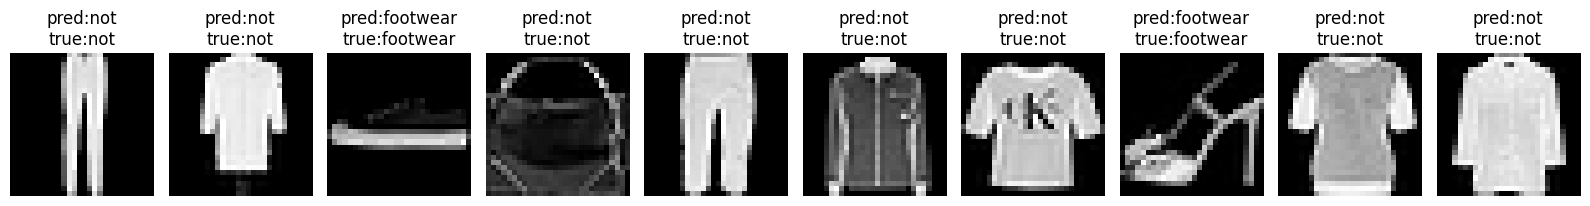

In [30]:
# quick test visualization
def quick_demo_on_test(n=8):
    idx = np.random.choice(len(x_test), size=n, replace=False)
    probs = model.predict(x_test[idx], verbose=0).reshape(-1)
    preds = (probs >= 0.5).astype(int)
    plt.figure(figsize=(16, 3))
    for i, j in enumerate(idx, 1):
        plt.subplot(1, n, i)
        plt.imshow(x_test[j].squeeze(), cmap="gray")
        t = f"pred:{'footwear' if preds[i-1]==1 else 'not'}\ntrue:{'footwear' if y_test_bin[j]==1 else 'not'}"
        plt.title(t)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

quick_demo_on_test(n=10)

In [ ]:

from PIL import ImageOps, ImageFilter
import numpy as np, pathlib, matplotlib.pyplot as plt

def load_and_preprocess_image(path, invert_if_bright=True):
    img = Image.open(path).convert("L")                 # grayscale
    img = ImageOps.fit(img, (28, 28), Image.BILINEAR)   # center crop + resize
    img = ImageOps.autocontrast(img)                    # stretch contrast

    arr0 = np.asarray(img).astype("float32") / 255.0
    if invert_if_bright:
        # estimate background from 1-pixel border
        border = np.concatenate([arr0[0,:], arr0[-1,:], arr0[:,0], arr0[:,-1]])
        if border.mean() > 0.55:                        # FMNIST has dark bg
            arr0 = 1.0 - arr0

    arr = arr0[np.newaxis, ..., np.newaxis]
    return arr

# visualize predictions on original images (left) and preprocessed 28x28 (right)
def predict_on_folder(folder_path, threshold=0.5):
    folder = pathlib.Path(folder_path)
    files = [p for p in folder.iterdir() if p.suffix.lower() in {".png", ".jpg", ".jpeg", ".bmp", ".webp"}]
    if not files:
        print("no images found")
        return

    n = len(files)
    plt.figure(figsize=(6*3, n*3))  # 3 panels per row

    for i, f in enumerate(files, 1):
        x = load_and_preprocess_image(str(f))
        prob = float(model.predict(x, verbose=0)[0][0])
        label = "footwear" if prob >= threshold else "not"

        # original
        plt.subplot(n, 3, (i-1)*3 + 1)
        img_rgb = Image.open(f).convert("RGB")
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title("original")

        # processed
        plt.subplot(n, 3, (i-1)*3 + 2)
        plt.imshow(x[0,...,0], cmap="gray", vmin=0, vmax=1)
        plt.axis("off")
        plt.title("processed 28x28")

        # text panel
        plt.subplot(n, 3, (i-1)*3 + 3)
        plt.axis("off")
        txt = f"class: {label}\nprob: {prob:.2f}"
        plt.text(0.5, 0.5, txt, ha="center", va="center", fontsize=14)

    plt.tight_layout()
    plt.show()



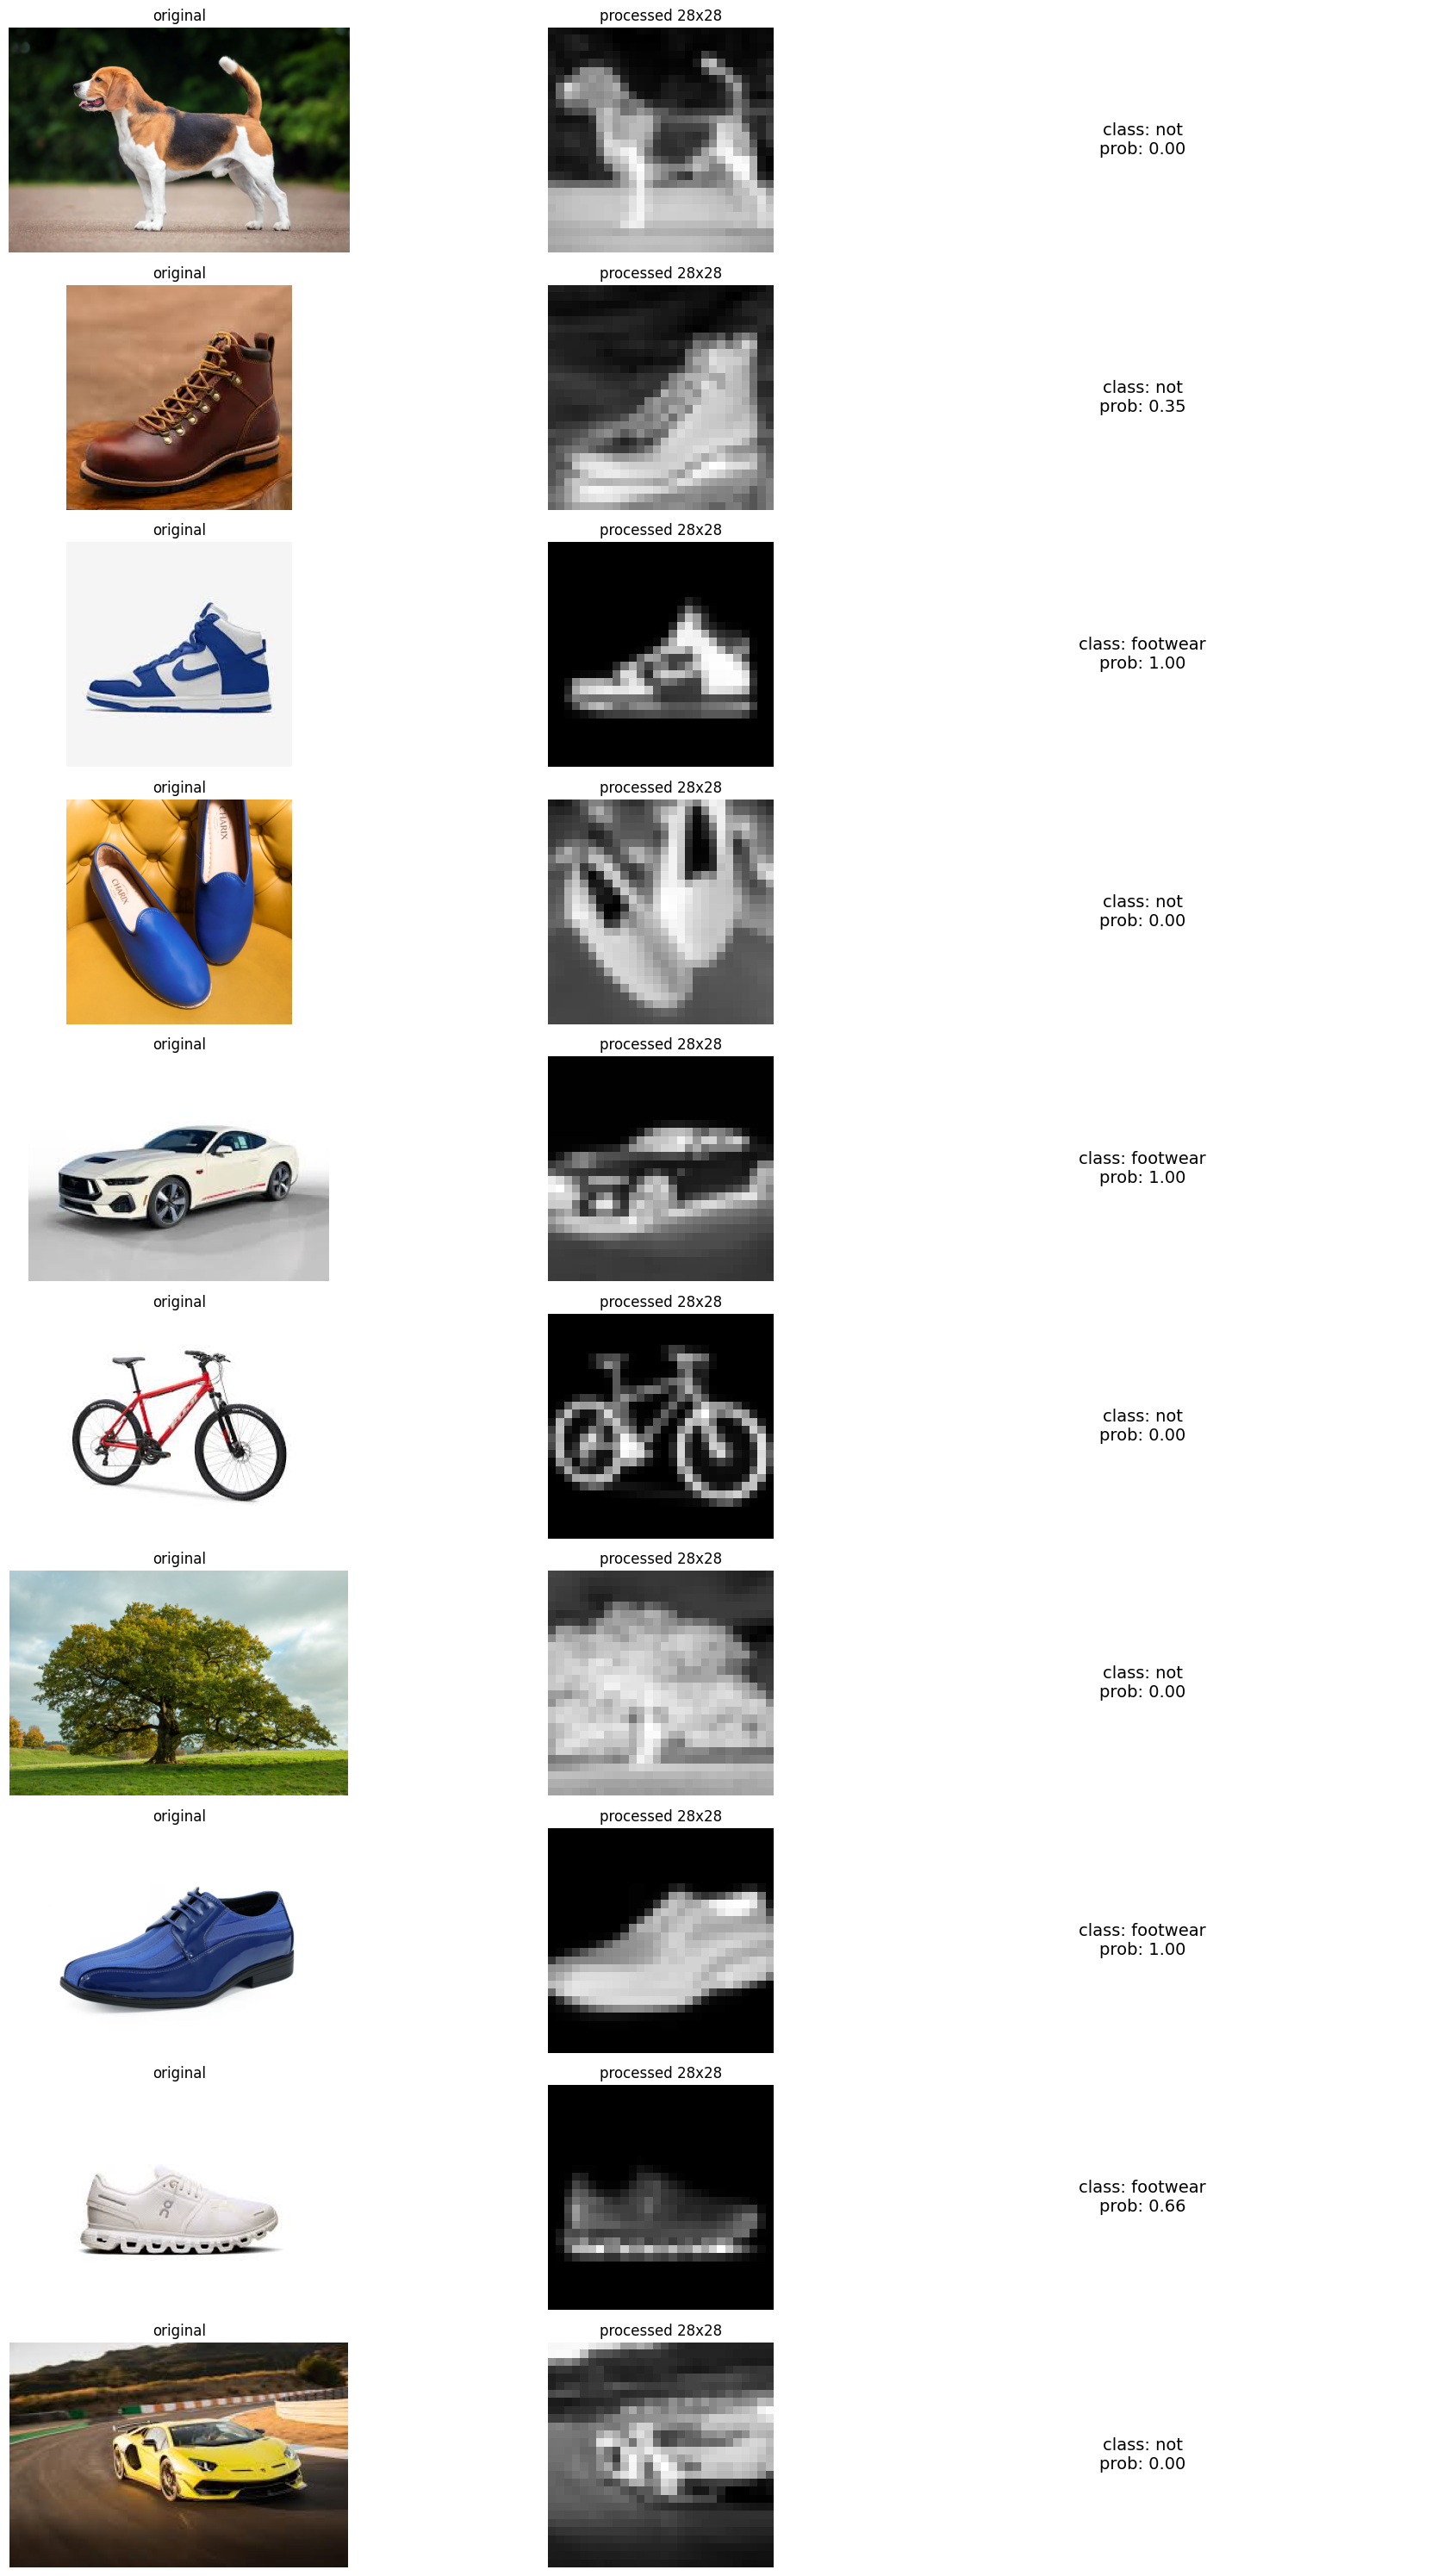

In [ ]:
# rebuild the model architecture
model = make_model()

# load the weights you saved earlier
weights_path = "footwear_cnn.weights.h5"
model.load_weights(weights_path)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)


# run predictions on unseen images
predict_on_folder("test_images_cnn")
